In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os.path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import time
import joblib
from sklearn.model_selection import cross_val_score

import get_metrics
import lazypredict
from lazypredict.Supervised import LazyClassifier

import sklearn
import xgboost
import lightgbm

from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from random import shuffle
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import plot_roc_curve

# LazyPredict output

In [3]:
pd.read_csv('models2.txt', sep='\t', index_col=0)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.99,1.00,1.00,0.99,2244.88
RandomForestClassifier,0.98,0.99,0.99,0.98,1910.82
XGBClassifier,0.98,0.98,0.98,0.98,763.03
BaggingClassifier,0.98,0.98,0.98,0.98,3184.50
LGBMClassifier,0.98,0.98,0.98,0.98,106.58
AdaBoostClassifier,0.98,0.98,0.98,0.98,1778.15
SGDClassifier,0.98,0.98,0.98,0.98,103.45
ExtraTreeClassifier,0.98,0.98,0.98,0.98,98.88
LogisticRegression,0.97,0.98,0.98,0.97,119.27


# Investigate Predictive Power

In [3]:
srr_names = ['ERR1831349',
             'ERR1831346',
             'ERR1831347',
             'ERR1831348',
             'ERR1831350',
             'ERR1831351',
             'ERR1831352',
             'ERR1831353',
             'ERR1905889',
             'ERR1905890',
             'SRR14724463',
             'SRR14724473',
             'SRR14724483',
             'SRR14724493', 
             'SRR14724503',
             'SRR14724513',
             'SRR2106342',
             'SRR2106344',
             'DRR189730',
             'DRR189731',
             'DRR189732']

In [4]:
#df = pd.read_pickle('ML_df.pkl')
df = pd.read_pickle('ML_df_joined_LR_feats.pkl')
#df = pd.read_pickle('ML_df_add_LR_feats.pkl')

X = df.drop(["IS_ARTIFACT"], axis=1) # drop labels
y = df["IS_ARTIFACT"].copy() # labels

In [5]:
cat_attribs = ['REF','ALT'] 
X_train_num = X.drop(cat_attribs, axis=1) 
num_attribs = list(X_train_num)

In [6]:
all_features = num_attribs + cat_attribs

In [7]:
len(all_features)

274

## Join all subfiles of predictive_power.py / predictive_power.sh into a single file before moving on to subsequent cells

In [ ]:
# For example, if ran 2 times we should have 2000 models trained (1000 for each instance) with file names something like: 
# pp1_joined_LR_feats.pkl
# pp2_joined_LR_feats.pkl

# join them into a single file 'predictive_power_joined_LR_feats.pkl' by concatenating them

In [8]:
with open('predictive_power_joined_LR_feats.pkl', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    # Keeps object type during pickling
    features_and_scores = pickle.load(f) 

In [9]:
# Calculates accuracy score of each feature

#all_features = num_attribs + cat_attribs
output = []
for feature in all_features:
    
    total_score = 0
    num_scores = 0
    for features, score in features_and_scores:
        if feature in features:
            total_score += score
            num_scores += 1
            
    if num_scores > 1: # yvonna did > prob to not bias features with only 1 model score
        avg_score = total_score / num_scores
        output.append((avg_score, feature, num_scores))
        
output.sort(reverse = True)
for score, feature, num_scores in output:
    print("{:.3f}:\t{:10}\t{} models".format(score, feature, num_scores))

print()
feature_order = [feature for (score, feature, _) in output]
print(feature_order)
print()

0.977:	AF        	114 models
0.977:	HIAF      	114 models
0.972:	HICNT     	117 models
0.971:	VD        	118 models
0.971:	SN        	105 models
0.886:	ADJAF     	98 models
0.675:	TTAA      	120 models
0.658:	TTTA      	119 models
0.654:	AAAA      	102 models
0.651:	TAAA      	112 models
0.649:	TATT      	122 models
0.648:	TTAT      	97 models
0.643:	ATAA      	124 models
0.643:	TATA      	112 models
0.640:	AAAT      	103 models
0.631:	TAAC      	115 models
0.631:	TTTT      	115 models
0.628:	AATA      	99 models
0.626:	ATTT      	106 models
0.626:	TAAT      	118 models
0.624:	REF       	116 models
0.622:	ATTA      	117 models
0.617:	ALT       	113 models
0.617:	TTTC      	113 models
0.616:	TTAG      	110 models
0.613:	HOMO_POLY_T	120 models
0.608:	AATT      	112 models
0.607:	GAAA      	114 models
0.606:	CCCC      	104 models
0.604:	TTAC      	99 models
0.603:	GGGG      	84 models
0.602:	AGGG      	115 models
0.602:	HOMO_POLY_A	124 models
0.599:	TCCC      	114 models
0.594:	GGGT      

In [11]:
output[:7]

[(0.9767777071635607, 'AF', 114),
 (0.9767255140469635, 'HIAF', 114),
 (0.9720100207222953, 'HICNT', 117),
 (0.9711714964767196, 'VD', 118),
 (0.9706657709218925, 'SN', 105),
 (0.8859719977695982, 'ADJAF', 98),
 (0.674516054701179, 'TTAA', 120)]

In [12]:
avg_accuracy = [score for score, feature, num_scores in output]
feat = [feature for score, feature, num_scores in output]

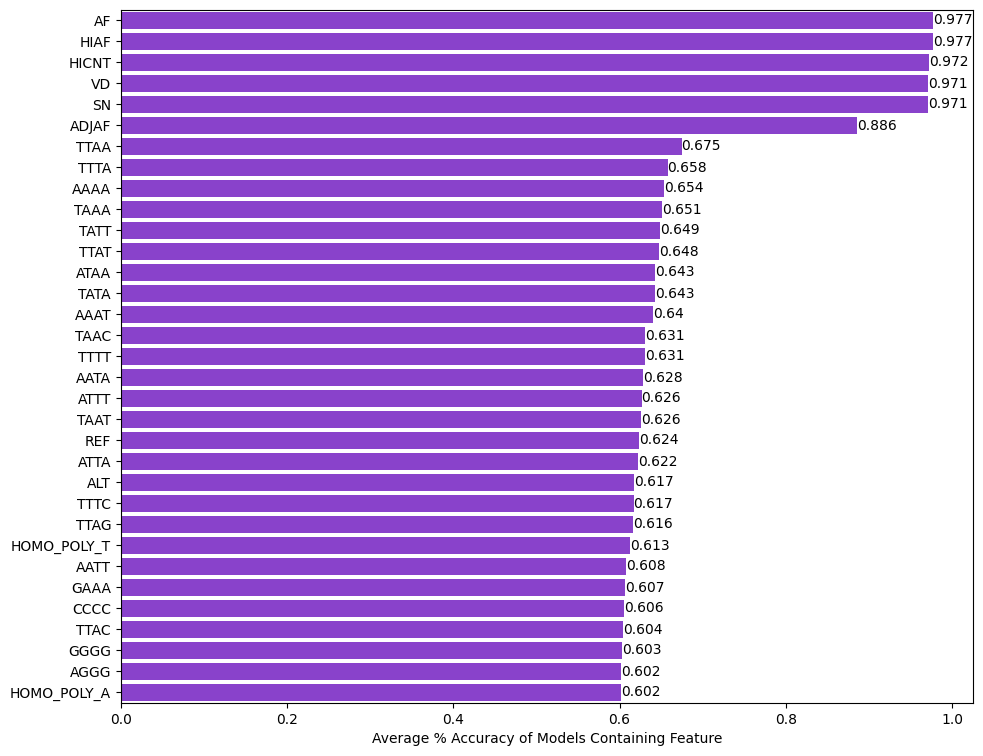

In [13]:
# Defining the plot size
fig, ax = plt.subplots(figsize=(11, 9))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x=avg_accuracy[:33], y=feat[:33], color='blueviolet')
 
labels = [round(acc, 3) for acc in avg_accuracy[:33]]  
ax.bar_label(ax.containers[0], labels=labels, label_type='edge', size=10)
#ax.bar_label(ax.containers[0], labels=labels, label_type='edge', size=13)    
    
# Setting the label for x-axis
plt.xlabel("Average % Accuracy of Models Containing Feature", size=10)
 
# Setting the label for y-axis
#plt.ylabel("Average % Accuracy of Models Containing Feature", size=10)
 
# Setting the title for the graph
#plt.title("Average % Accuracy of Models Containing Feature")
 
# Finally showing the plot
#plt.show()
plt.savefig('feature_importance.png', bbox_inches='tight')